# Pset3.5

In [14]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the data

In [6]:
A = imread('mandrill-large.tiff')
B = imread('mandrill-small.tiff')

### Let's take a look at the data

In [7]:
print(A.shape)
print(B.shape)

(512, 512, 3)
(128, 128, 3)


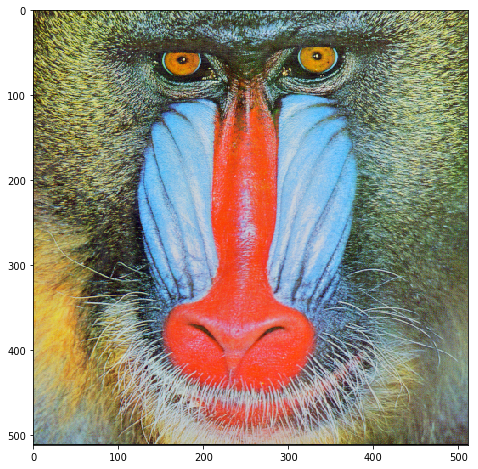

In [5]:
plt.imshow(A)

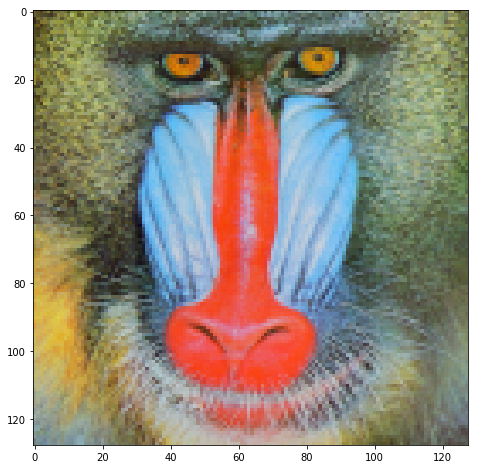

In [8]:
plt.imshow(B)

## K-means Code

In [553]:
def k_means_tiled(img, iters=30, n_centroids=16):
    img_size = img.shape[0]
    img_depth = img.shape[2]
    img_size_squared = img_size**2
    img_flat = np.reshape(img,(img_size_squared,img_depth))
    tiled_img = np.tile(img_flat,(n_centroids,1,1))

    ## take samples of img to start off
    sample_indices = np.random.randint(0, high=img_size-1, size=(n_centroids,2))
    ## tile centroids for speed
    centroids = np.asarray([np.tile(img[index[0]][index[1]], (img_size_squared,1)) for index in sample_indices])
    
    ## loop for iter range or stop if converged
    for it in range(iters):
        ## Dist between img and current centroids
        sub_sq_sum = np.sum(np.square(-1*centroids + tiled_img), axis=2)
        
        ## Take centroid with min val
        min_c = np.argmin(sub_sq_sum,axis=0)
        bincount = np.bincount(min_c)

        ## Take mean of points in centroid's group for new centroids
        new_centroids = np.zeros((n_centroids,img_size_squared,img_depth))
        for i in range(n_centroids):
            c_mask = min_c==i
            c_group_sum = np.sum(img_flat[c_mask], axis=0)
            if c_group_count == 0:
                new_centroids[i] = centroids[i]
                continue

            new_centroid = c_group_sum/bincount[i]
            new_centroids[i] = np.tile(np.round(new_centroid),(img_size_squared,1))

        ## break early if converged
        if np.sum(new_centroids-centroids) == 0:
            print('converged')
            return new_centroids[:,0]
        
        ## set centroids for next iteration
        centroids = new_centroids
        
    return centroids[:,0]

def compress_img_tiled(img, centroids):
    img_size = img.shape[0]
    img_depth = img.shape[2]
    n_centroids = centroids.shape[0]
    img_size_squared = img_size**2
    img_flat = np.reshape(img,(img_size_squared,img_depth))
    
    # re-tile centroids
    tiled_centroids = np.asarray([np.tile(pixel, (img_size_squared,1)) for pixel in centroids])

    ## Dist between img and current centroids
    sub_sq_sum = np.sum(np.square(-1*tiled_centroids + np.tile(img_flat,(n_centroids,1,1))), axis=2)
    min_c = np.argmin(sub_sq_sum, axis=0)
    
    ## Recreate image from centroids
    img = centroids[min_c].reshape((img_size,img_size,img_depth)).astype('uint8')

    color_profile = centroids.reshape(1,n_centroids,img_depth).astype('uint8')
    return img, color_profile

## Run K-means on small

In [545]:
centroids = k_means_tiled(B, n_centroids=16, iters=60)

converged


In [546]:
compressed_img, color_profile = compress_img_tiled(B, centroids)

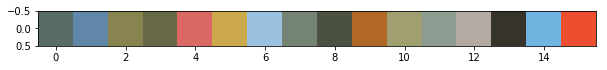

In [547]:
plt.imshow(color_profile)

### Compare to B

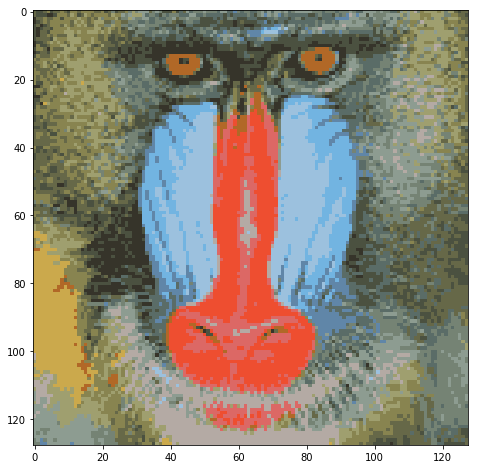

In [548]:
plt.imshow(compressed_img)

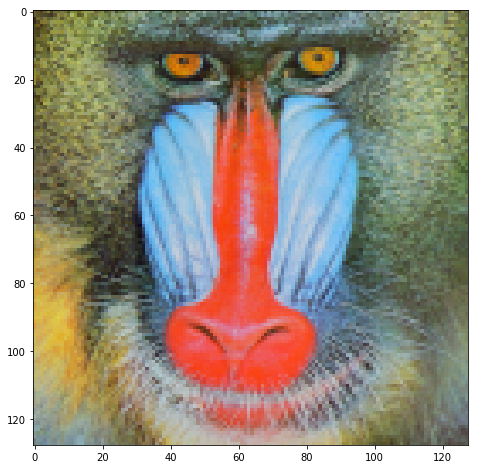

In [549]:
plt.imshow(B)

## Compress large image using small image's centroids

In [550]:
compressed_A, _ = compress_img_tiled(A, centroids)

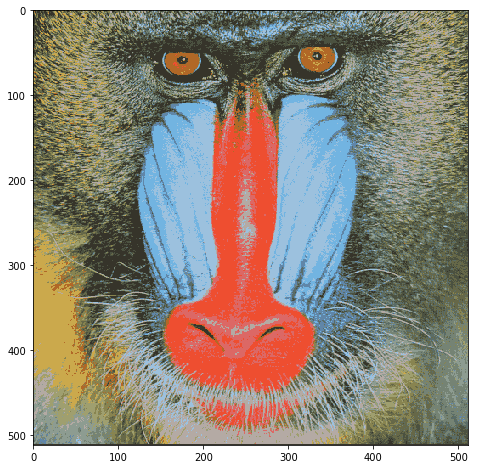

In [551]:
plt.imshow(compressed_A)

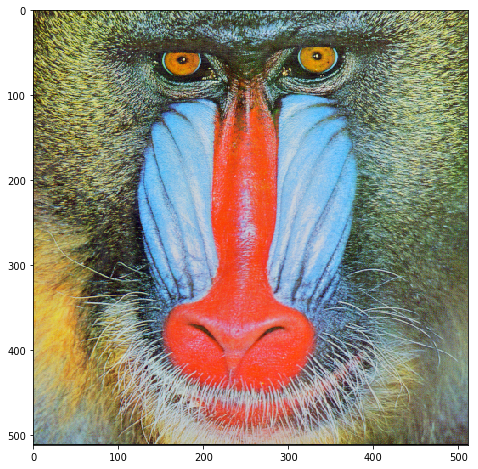

In [552]:
plt.imshow(A)

## Part d
If the original image was unique with each pixel, then there are $512^2 \cdot 256^3$ potentially unique entries. With only 16 colors, this changes to $512^2\cdot16$, which corresponds to a factor of $\frac{512^2 \cdot 256^3}{512^2 \cdot 16} = 2^{20}$.